<a href="https://colab.research.google.com/github/bosszonke8276/Lab1AI/blob/main/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [2]:
ensemble_error(n_classifier=11, error=0.25)

np.float64(0.03432750701904297)

In [3]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
# So error_range is an array of possible individual classifier error rates ranging from 0.00 to 1.00 in increments of 0.01.
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
# ens_errors is a list of ensemble error rates corresponding to each classifier error in error_range.

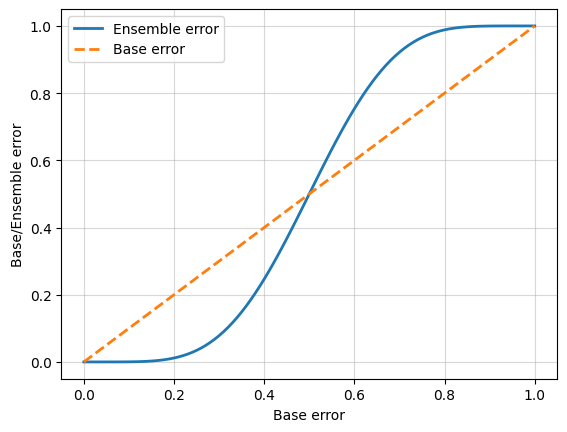

In [4]:
import matplotlib.pyplot as plt

plt.plot(error_range,
         ens_errors,
         label='Ensemble error',
         linewidth=2)

plt.plot(error_range,
         error_range,
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('images/07_03.png', dpi=300)
plt.show()

In [5]:
import numpy as np

np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

np.int64(1)

In [10]:
ex = np.array([[0.9, 0.1],    # Model 1's probabilities: 90% Class 0, 10% Class 1
               [0.8, 0.2],   # Model 2: 80% Class 0, 20% Class 1
               [0.4, 0.6]])   # Model 3: 40% Class 0, 60% Class 1

p = np.average(ex,
               axis=0,         # Average across models (rows), per class (columns)
               weights=[0.2, 0.2, 0.6])

In [11]:
np.argmax(p)

np.int64(0)

In [12]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [14]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y,
                        test_size=0.5,
                        random_state=1,
                        stratify=y)

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [16]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

print('10-fold cross validation:\n')

for clf, label in zip(all_clf, clf_labels):
    scores = []
    if label == 'Majority voting':
        # Manually perform cross-validation for MajorityVoteClassifier
        # to use predict_proba for ROC AUC calculation
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        for train_index, test_index in skf.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            # Fit the classifier on the training fold
            clf.fit(X_train_fold, y_train_fold)

            # Get probability estimates for the test fold
            y_pred_proba = clf.predict_proba(X_test_fold)[:, 1] # Get probability of positive class

            # Calculate ROC AUC for the fold
            score = roc_auc_score(y_test_fold, y_pred_proba)
            scores.append(score)
        scores = np.array(scores)
    else:
        # Use cross_val_score for other classifiers
        scores = cross_val_score(estimator=clf,
                                 X=X_train,
                                 y=y_train,
                                 cv=10,
                                 scoring='roc_auc')

    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.95 (+/- 0.11) [Majority voting]


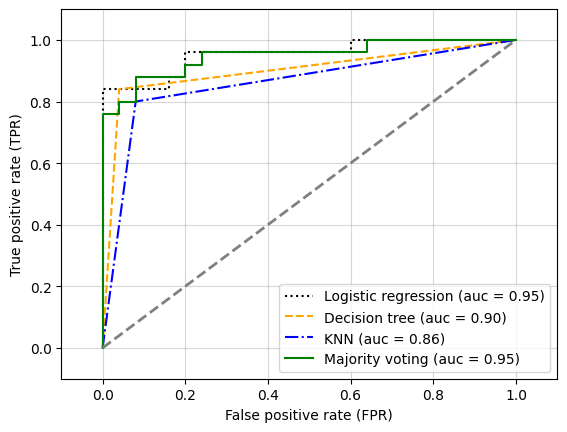

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

In [18]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

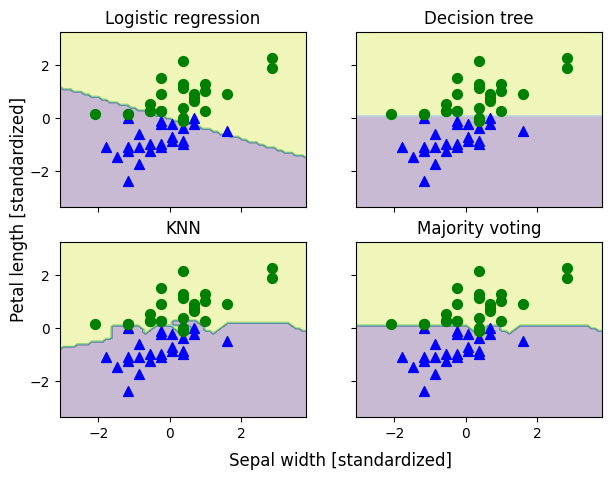

In [19]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

In [20]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [21]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r],
             grid.cv_results_['std_test_score'][r] / 2.0,
             grid.cv_results_['params'][r]))

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
from itertools import product

# Define the parameter grid
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

# Initialize variables to store best parameters and score
best_score = -np.inf
best_params = {}

# Manual Grid Search and Cross-Validation
for max_depth, C in product(params['decisiontreeclassifier__max_depth'],
                           params['pipeline-1__clf__C']):

    # Update parameters for the current combination
    mv_clf.set_params(decisiontreeclassifier__max_depth=max_depth,
                     **{'pipeline-1__clf__C': C}) # Pass parameter name as string

    scores = []
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Fit the classifier on the training fold
        mv_clf.fit(X_train_fold, y_train_fold)

        # Get probability estimates for the test fold
        y_pred_proba = mv_clf.predict_proba(X_test_fold)[:, 1] # Get probability of positive class

        # Calculate ROC AUC for the fold
        score = roc_auc_score(y_test_fold, y_pred_proba)
        scores.append(score)

    mean_score = np.mean(scores)
    std_score = np.std(scores)

    print("%0.3f +/- %0.2f {'decisiontreeclassifier__max_depth': %d, 'pipeline-1__clf__C': %f}"
          % (mean_score, std_score / 2.0, max_depth, C))

    # Check if current combination is the best
    if mean_score > best_score:
        best_score = mean_score
        best_params = {'decisiontreeclassifier__max_depth': max_depth,
                       'pipeline-1__clf__C': C}

print("\nBest parameters: %r" % best_params)
print("Best ROC AUC score: %0.3f" % best_score)

0.950 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001000}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.100000}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.000000}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001000}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.100000}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.000000}

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
Best ROC AUC score: 1.000


In [23]:

grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [24]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     LogisticRegression(C=100.0,
                                                                        random_state=1)]]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=2,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     KNeighborsClassifier(n_neighbors=1)]])])

In [25]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     LogisticRegression(C=100.0,
                                                                        random_state=1)]]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=2,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ['clf',
                                                     KNeighborsClassifier(n_neighbors=1)]])])

In [26]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y,
                             test_size=0.2,
                             random_state=1,
                             stratify=y)

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(estimator=tree, # Changed base_estimator to estimator
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [29]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


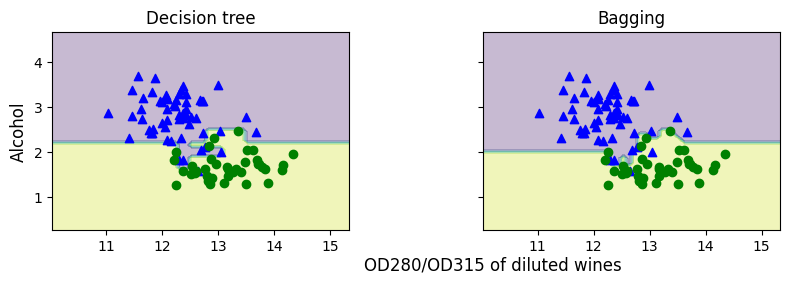

In [30]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(estimator=tree, # Changed base_estimator to estimator
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

In [32]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 0.968/0.917


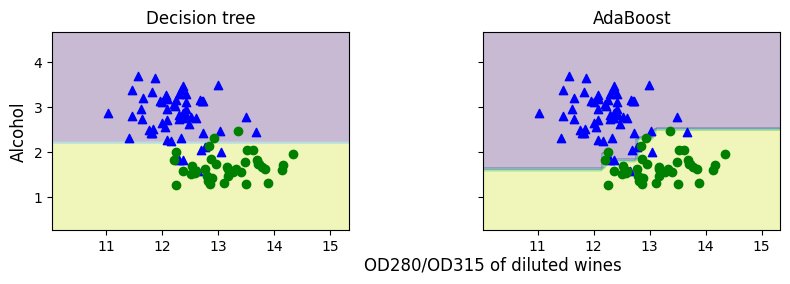

In [33]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
#plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()